In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

In [88]:
warnings.filterwarnings('ignore')

In [89]:
clinical = pd.read_csv(r"D:\Projects\Cardiac Patient Monitoring System\lstm data\clinical_info.csv")

In [177]:

def assign_risk_label(row):
    if row["death_inhosp"] == 1:
        return 2  # Critical
    elif row["icu_days"] >= 3:
        return 1  # Moderate
    else:
        return 0  # Stable

In [178]:
clinical["risk_label"] = clinical.apply(assign_risk_label, axis=1)

print(clinical["risk_label"].value_counts())

print(clinical["risk_label"].value_counts(normalize=True))

risk_label
0    6065
1     266
2      57
Name: count, dtype: int64
risk_label
0    0.949436
1    0.041641
2    0.008923
Name: proportion, dtype: float64


In [179]:
clinical['bun_cr_ratio'] = clinical['preop_bun'] / (clinical['preop_cr'] + 1e-3)
clinical['na_k_ratio'] = clinical['preop_na'] / (clinical['preop_k'] + 1e-3)
clinical['htn_dm'] = clinical['preop_htn'].apply(lambda x: 1 if x == 'Y' else 0) + clinical['preop_dm'].apply(lambda x: 1 if x == 'Y' else 0)
clinical['hb_by_bun'] = clinical['preop_hb'] / (clinical['preop_bun'] + 1e-3)
clinical['alb_by_cr'] = clinical['preop_alb'] / (clinical['preop_cr'] + 1e-3)
clinical['electrolyte_ratio'] = clinical['preop_na'] / (clinical['preop_k'] + 1e-3)
clinical['gluc_by_bmi'] = clinical['preop_gluc'] / (clinical['bmi'] + 1e-3)
clinical['hb_by_weight'] = clinical['preop_hb'] / (clinical['weight'] + 1e-3)
clinical['plt_by_pt'] = clinical['preop_plt'] / (clinical['preop_pt'] + 1e-3)

In [180]:
clinical['bmi_category'] = pd.cut(clinical['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], 
                                 labels=['underweight', 'normal', 'overweight', 'obese'])
clinical['age_group'] = pd.cut(clinical['age'], bins=[0, 40, 60, 80, 200], 
                              labels=['young', 'middle', 'senior', 'elderly'])

In [181]:
selected_features = [
    'age', 'sex', 'bmi', 'age_group', 'bmi_category',
    'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft',
    'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt',
    'preop_na', 'preop_k', 'preop_gluc', 'preop_alb',
    'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr',
    'bun_cr_ratio', 'na_k_ratio', 'htn_dm', 'hb_by_bun', 'alb_by_cr',
    'electrolyte_ratio', 'gluc_by_bmi', 'hb_by_weight', 'plt_by_pt'
]



In [182]:
df = clinical[selected_features + ['risk_label']].copy()
df = df.dropna()

In [183]:
print(df.shape)

(5617, 31)


In [184]:
df['preop_htn'] = df['preop_htn'].replace({1: 'Y', 0: 'N'})
df['preop_dm'] = df['preop_dm'].replace({1: 'Y', 0: 'N'})

In [ ]:

X = df.drop('risk_label', axis=1)
y = df['risk_label']

In [186]:
categorical_cols = ['sex', 'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'bmi_category', 'age_group']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [187]:
print(len(numeric_cols))
print(len(categorical_cols))

23
7


In [ ]:


from sklearn.preprocessing import OneHotEncoder


sex_categories = ['F', 'M']
preop_htn_categories = ['N', 'Y']
preop_dm_categories = ['N', 'Y']
preop_ecg_categories = clinical['preop_ecg'].dropna().unique().tolist()
preop_pft_categories = clinical['preop_pft'].dropna().unique().tolist()
bmi_category_categories = ['underweight', 'normal', 'overweight', 'obese']
age_group_categories = ['young', 'middle', 'senior', 'elderly']


encoder = OneHotEncoder(
    handle_unknown='ignore',
    drop='first',
    categories=[
        sex_categories,
        preop_htn_categories,
        preop_dm_categories,
        preop_ecg_categories,
        preop_pft_categories,
        bmi_category_categories,
        age_group_categories
    ]
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', encoder, categorical_cols)
])


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [149]:
print(X_train.shape)
print(X_test.shape)

(4493, 30)
(1124, 30)


In [190]:
cat_encoder = loaded_preprocessor.named_transformers_['cat']

for col, cats in zip(categorical_cols, cat_encoder.categories_):
    print(f"{col}: {cats}")


sex: ['F' 'M']
preop_htn: ['N' 'Y']
preop_dm: ['N' 'Y']
preop_ecg: ['Normal Sinus Rhythm' 'Left anterior fascicular block'
 '1st degree A-V block, Left bundle branch block' '1st degree A-V block'
 'Atrial fibrillation'
 'Incomplete right bundle branch block, Left anterior fascicular block'
 'Atrial fibrillation, Right bundle branch block'
 'Premature supraventricular and ventricular complexes, Right bundle branch block'
 'Atrial fibrillation with slow ventricular response'
 'Right bundle branch block' 'Incomplete right bundle branch block'
 'Left anterior hemiblock'
 'Atrial fibrillation with rapid ventricular response'
 'Premature ventricular complexes' 'Left posterior fascicular block'
 'Atrial fibrillation with premature ventricular, Incomplete left bundle block'
 'Premature atrial complexes'
 '1st degree A-V block with Premature supraventricular complexes, Left bundle branch block'
 '1st degree A-V block with Premature atrial complexes'
 'Atrial fibrillation with premature ventricu

In [150]:
print(X_train[categorical_cols].dtypes)
print(X_train[categorical_cols].head())


sex               object
preop_htn         object
preop_dm          object
preop_ecg         object
preop_pft         object
bmi_category    category
age_group       category
dtype: object
     sex preop_htn preop_dm            preop_ecg             preop_pft  \
1408   F         Y        N  Normal Sinus Rhythm      Mild restrictive   
841    M         N        N  Normal Sinus Rhythm                Normal   
487    F         N        N  Normal Sinus Rhythm                Normal   
461    F         Y        N  Normal Sinus Rhythm  Moderate obstructive   
696    M         N        N  Normal Sinus Rhythm                Normal   

     bmi_category age_group  
1408   overweight    middle  
841        normal     young  
487        normal    middle  
461        normal   elderly  
696   underweight    middle  


In [151]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [152]:

print(pd.Series(y_train).value_counts())

risk_label
0    4273
1     185
2      35
Name: count, dtype: int64


In [ ]:
#  SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_processed, y_train)

# SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_processed, y_train)

print(f"\nSMOTE: {pd.Series(y_train_smote).value_counts()}")
print(f"ADASYN: {pd.Series(y_train_adasyn).value_counts()}")
print(f"SMOTETomek: {pd.Series(y_train_smotetomek).value_counts()}")


بعد SMOTE: risk_label
0    4273
1    4273
2    4273
Name: count, dtype: int64
بعد ADASYN: risk_label
2    4283
1    4277
0    4273
Name: count, dtype: int64
بعد SMOTETomek: risk_label
2    4273
0    4272
1    4272
Name: count, dtype: int64


In [154]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

{0: 0.35049535845229735, 1: 8.095495495495495, 2: 42.79047619047619}


In [155]:
def create_models():
    # XGBoost 
    xgb_balanced = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        scale_pos_weight=1,
        tree_method='hist'
    )
    
    # Random Forest 
    rf_balanced = RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # LightGBM 
    lgbm_balanced = LGBMClassifier(
        objective='multiclass',
        num_class=3,
        class_weight='balanced',
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1
    )
    
    return xgb_balanced, rf_balanced, lgbm_balanced

In [156]:
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, method_name):
    print(method_name)
    
    model.fit(X_train_data, y_train_data)
    y_pred = model.predict(X_test_data)
    
    accuracy = accuracy_score(y_test_data, y_pred)
    f1_macro = f1_score(y_test_data, y_pred, average='macro')
    f1_weighted = f1_score(y_test_data, y_pred, average='weighted')
    
    print(f"accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    
    print("\nclassification_report:")
    print(classification_report(y_test_data, y_pred))
    
    print("\nconfusion_matrix:")
    print(confusion_matrix(y_test_data, y_pred))
    
    return accuracy, f1_macro, f1_weighted


results = {}

In [ ]:

xgb_model, rf_model, lgbm_model = create_models()
acc, f1_mac, f1_wei = evaluate_model(xgb_model, X_train_smote, y_train_smote, 
                                    X_test_processed, y_test, "XGBoost + SMOTE")
results['XGBoost_SMOTE'] = {'accuracy': acc, 'f1_macro': f1_mac, 'f1_weighted': f1_wei}

XGBoost + SMOTE
accuracy: 0.9671
F1-Score (Macro): 0.5840
F1-Score (Weighted): 0.9610

classification_report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1069
           1       0.75      0.46      0.57        46
           2       1.00      0.11      0.20         9

    accuracy                           0.97      1124
   macro avg       0.91      0.52      0.58      1124
weighted avg       0.96      0.97      0.96      1124


confusion_matrix:
[[1065    4    0]
 [  25   21    0]
 [   5    3    1]]


In [ ]:

xgb_model, rf_model, lgbm_model = create_models()
acc, f1_mac, f1_wei = evaluate_model(rf_model, X_train_adasyn, y_train_adasyn, 
                                    X_test_processed, y_test, "Random Forest + ADASYN")
results['RF_ADASYN'] = {'accuracy': acc, 'f1_macro': f1_mac, 'f1_weighted': f1_wei}

Random Forest + ADASYN
accuracy: 0.9680
F1-Score (Macro): 0.5867
F1-Score (Weighted): 0.9617

classification_report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1069
           1       0.78      0.46      0.58        46
           2       1.00      0.11      0.20         9

    accuracy                           0.97      1124
   macro avg       0.92      0.52      0.59      1124
weighted avg       0.96      0.97      0.96      1124


confusion_matrix:
[[1066    3    0]
 [  25   21    0]
 [   5    3    1]]


In [159]:
# 3. LightGBM مع SMOTETomek
xgb_model, rf_model, lgbm_model = create_models()
acc, f1_mac, f1_wei = evaluate_model(lgbm_model, X_train_smotetomek, y_train_smotetomek, 
                                    X_test_processed, y_test, "LightGBM + SMOTETomek")
results['LGBM_SMOTETomek'] = {'accuracy': acc, 'f1_macro': f1_mac, 'f1_weighted': f1_wei}


LightGBM + SMOTETomek
accuracy: 0.9635
F1-Score (Macro): 0.5561
F1-Score (Weighted): 0.9559

classification_report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1069
           1       0.71      0.37      0.49        46
           2       1.00      0.11      0.20         9

    accuracy                           0.96      1124
   macro avg       0.89      0.49      0.56      1124
weighted avg       0.96      0.96      0.96      1124


confusion_matrix:
[[1065    4    0]
 [  29   17    0]
 [   5    3    1]]


In [ ]:


xgb_best, rf_best, lgbm_best = create_models()

xgb_best.fit(X_train_smote, y_train_smote)
rf_best.fit(X_train_smote, y_train_smote)
lgbm_best.fit(X_train_smote, y_train_smote)

LGBMClassifier(class_weight='balanced', max_depth=6, n_estimators=300,
               num_class=3, objective='multiclass', random_state=42,
               verbose=-1)

In [161]:
#  Ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_best),
        ('rf', rf_best),
        ('lgbm', lgbm_best)
    ], 
    voting='soft'
)

In [162]:
ensemble_model.fit(X_train_smote, y_train_smote)
acc, f1_mac, f1_wei = evaluate_model(ensemble_model, X_train_smote, y_train_smote, 
                                    X_test_processed, y_test, "Ensemble + SMOTE")
results['Ensemble_SMOTE'] = {'accuracy': acc, 'f1_macro': f1_mac, 'f1_weighted': f1_wei}

Ensemble + SMOTE
accuracy: 0.9689
F1-Score (Macro): 0.5968
F1-Score (Weighted): 0.9634

classification_report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1069
           1       0.77      0.50      0.61        46
           2       1.00      0.11      0.20         9

    accuracy                           0.97      1124
   macro avg       0.91      0.54      0.60      1124
weighted avg       0.97      0.97      0.96      1124


confusion_matrix:
[[1065    4    0]
 [  23   23    0]
 [   5    3    1]]


In [163]:

results_df = pd.DataFrame(results).T
print(results_df)

                 accuracy  f1_macro  f1_weighted
XGBoost_SMOTE    0.967082  0.583952     0.960954
RF_ADASYN        0.967972  0.586700     0.961718
LGBM_SMOTETomek  0.963523  0.556062     0.955877
Ensemble_SMOTE   0.968861  0.596821     0.963363


In [164]:

best_model_name = results_df['f1_macro'].idxmax()
print(f"\n best model: {best_model_name}")
print(f"F1-Score (Macro): {results_df.loc[best_model_name, 'f1_macro']:.4f}")


 best model: Ensemble_SMOTE
F1-Score (Macro): 0.5968


In [ ]:
# save best model
if best_model_name == 'Ensemble_SMOTE':
    best_model = ensemble_model
    best_preprocessing = preprocessor
    
    #save model
    joblib.dump(best_model, 'best_cardiac_risk_model.pkl')
    joblib.dump(best_preprocessing, 'cardiac_risk_preprocessor.pkl')
    joblib.dump(smote, 'cardiac_risk_smote.pkl')
    

    

    if hasattr(best_model.named_estimators_['xgb'], 'feature_importances_'):
        feature_names = (numeric_cols + 
                        list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))
        
        importances = best_model.named_estimators_['xgb'].feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        

        print(feature_importance_df.head(10))





تم حفظ أفضل نموذج بنجاح!

أهم 10 متغيرات:
                                 feature  importance
34   preop_ecg_Right bundle branch block    0.102280
23                                 sex_M    0.070598
41  preop_ecg_Premature atrial complexes    0.069257
28        preop_ecg_1st degree A-V block    0.050359
63                      age_group_middle    0.049961
57          preop_pft_Severe restrictive    0.041781
29         preop_ecg_Atrial fibrillation    0.040441
9                              preop_alb    0.040157
53            preop_pft_Mild restrictive    0.031163
52            preop_pft_Mild obstructive    0.029698


In [166]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ensemble_model, X_train_smote, y_train_smote, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='f1_macro')

print(f"\nCross-Validation F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-Validation F1-Score: 0.9942 (+/- 0.0042)


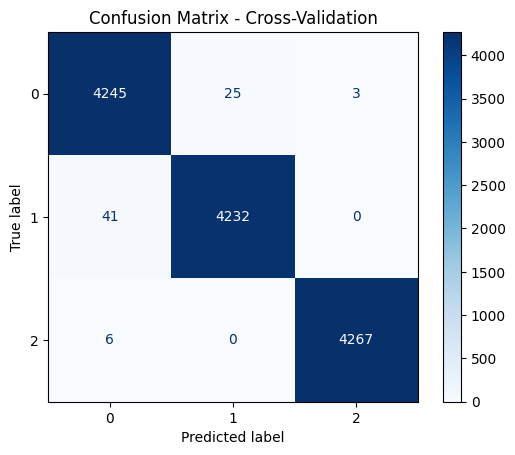


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4273
           1       0.99      0.99      0.99      4273
           2       1.00      1.00      1.00      4273

    accuracy                           0.99     12819
   macro avg       0.99      0.99      0.99     12819
weighted avg       0.99      0.99      0.99     12819



In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_cv_preXXX= cross_val_predict(ensemble_model, X_train_smote, y_train_smote,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))


cm = confusion_matrix(y_train_smote, y_cv_preXXX)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Cross-Validation")
plt.show()


print("\nClassification Report:")
print(classification_report(y_train_smote, y_cv_preXXX))


## loading model

In [172]:
loaded_model = joblib.load(os.path.join(model_dir, 'cardiac_risk_ensemble_model.pkl'))
loaded_preprocessor = joblib.load(os.path.join(model_dir, 'cardiac_risk_preprocessor.pkl'))


In [173]:

sample_data = pd.DataFrame({
    'age': [65],
    'sex': ['M'],
    'bmi': [28.5],
    'age_group': ['senior'],
    'bmi_category': ['overweight'],
    'preop_htn': ['Y'],
    'preop_dm': ['N'],
    'preop_ecg': ['Normal'],
    'preop_pft': ['Normal'],
    'preop_hb': [12.5],
    'preop_plt': [250000],
    'preop_pt': [12.8],
    'preop_aptt': [28.5],
    'preop_na': [140],
    'preop_k': [4.2],
    'preop_gluc': [110],
    'preop_alb': [3.8],
    'preop_ast': [28],
    'preop_alt': [32],
    'preop_bun': [18],
    'preop_cr': [1.1],
    'bun_cr_ratio': [18/1.1],
    'na_k_ratio': [140/4.2],
    'htn_dm': [1],
    'hb_by_bun': [12.5/18],
    'alb_by_cr': [3.8/1.1],
    'electrolyte_ratio': [140/4.2],
    'gluc_by_bmi': [110/28.5],
    'hb_by_weight': [12.5/75],  
    'plt_by_pt': [250000/12.8]
})


print(sample_data.head())

   age sex   bmi age_group bmi_category preop_htn preop_dm preop_ecg  \
0   65   M  28.5    senior   overweight         Y        N    Normal   

  preop_pft  preop_hb  ...  preop_cr  bun_cr_ratio  na_k_ratio  htn_dm  \
0    Normal      12.5  ...       1.1     16.363636   33.333333       1   

   hb_by_bun  alb_by_cr  electrolyte_ratio  gluc_by_bmi  hb_by_weight  \
0   0.694444   3.454545          33.333333     3.859649      0.166667   

   plt_by_pt  
0   19531.25  

[1 rows x 30 columns]


In [174]:

sample_processed = loaded_preprocessor.transform(sample_data)

print(f" {sample_processed.shape}")


 (1, 66)


In [175]:

prediction = loaded_model.predict(sample_processed)
prediction_proba = loaded_model.predict_proba(sample_processed)

In [176]:
risk_levels = {0: ' (Stable)', 1: ' (Moderate)', 2: ' (Critical)'}

print("\n===prediction ===")
print(f"  {prediction[0]}    ---- {risk_levels[prediction[0]]}")

for i, prob in enumerate(prediction_proba[0]):
    print(f"  {risk_levels[i]}: {prob:.4f} ({prob*100:.2f}%)")


===prediction ===
  0    ----  (Stable)
   (Stable): 0.9283 (92.83%)
   (Moderate): 0.0421 (4.21%)
   (Critical): 0.0296 (2.96%)
